In [52]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
import optuna

from scipy.stats import shapiro
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
accuracy_score)

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [53]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


I can see some null values, I will try to figure out how many of them is in the dataframe

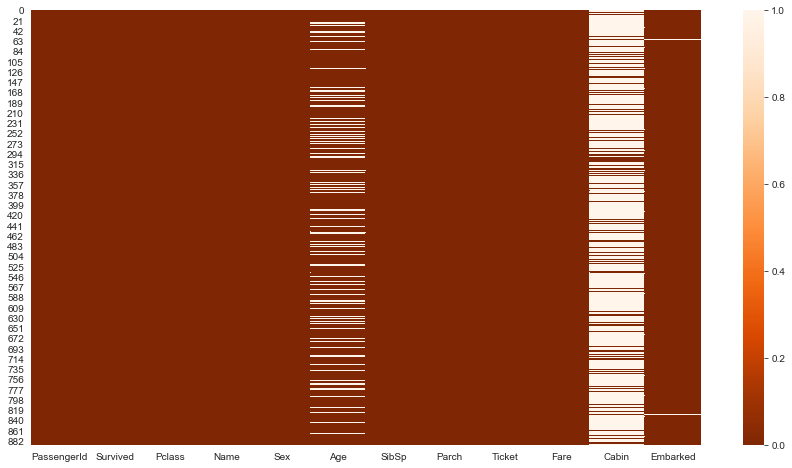

In [54]:
plt.figure(figsize=(15,8))
sns.heatmap(df.isnull(),cmap='Oranges_r')

In [55]:
df.dropna(subset=['Embarked'], inplace=True)

In [56]:
df['Cabin'].isnull().value_counts()

True     687
False    202
Name: Cabin, dtype: int64

In [57]:
df.drop('Cabin',axis=1,inplace=True)

df['Age'].isnull().value_counts()

False    712
True     177
Name: Age, dtype: int64

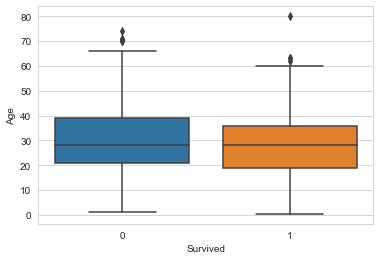

In [58]:
#looking for correlated variables
sns.boxplot(x='Survived', y='Age',data=df)

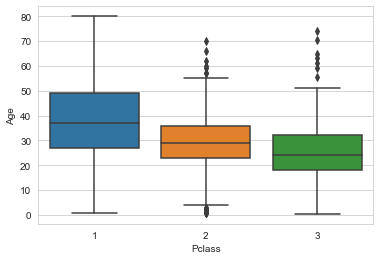

In [59]:
sns.boxplot(x='Pclass', y='Age',data=df)

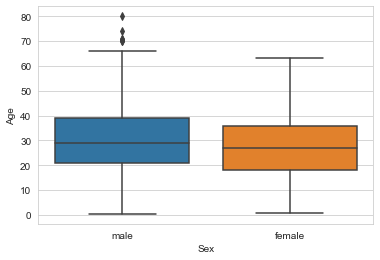

In [60]:
sns.boxplot(x='Sex', y='Age', data=df)

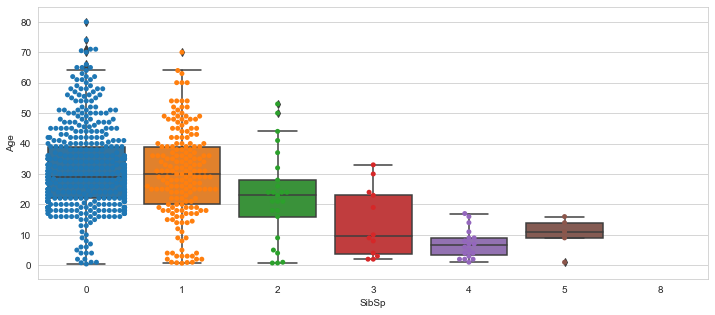

In [61]:
plt.figure(figsize=(12,5))
sns.boxplot(x='SibSp', y='Age', data=df)
sns.swarmplot(x= 'SibSp', y='Age', data=df)

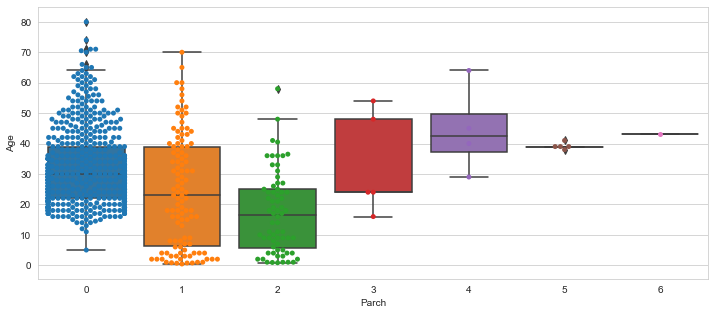

In [62]:
plt.figure(figsize=(12,5))
sns.boxplot(x='Parch', y='Age', data=df)
sns.swarmplot(x= 'Parch', y='Age', data=df)

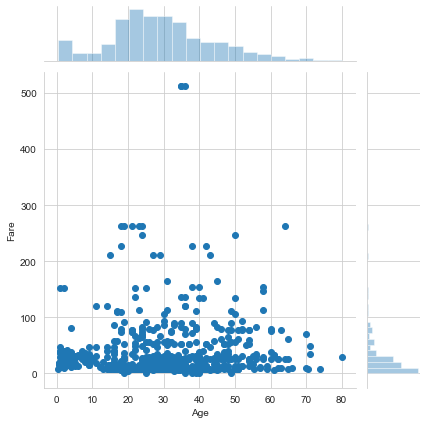

In [63]:
sns.jointplot(x='Age',y='Fare',data=df)

In [64]:
df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005028,-0.035330,0.033681,-0.057686,-0.001657,0.012703
Survived,-0.005028,1.000000,-0.335549,-0.082446,-0.034040,0.083151,0.255290
Pclass,-0.035330,-0.335549,1.000000,-0.365902,0.081656,0.016824,-0.548193
Age,0.033681,-0.082446,-0.365902,1.000000,-0.307351,-0.187896,0.093143
SibSp,-0.057686,-0.034040,0.081656,-0.307351,1.000000,0.414542,0.160887
Parch,-0.001657,0.083151,0.016824,-0.187896,0.414542,1.000000,0.217532
Fare,0.012703,0.255290,-0.548193,0.093143,0.160887,0.217532,1.000000


In [65]:
#filling null values in class column based on age
def null_filler(cols):
    
    Pclass=cols[0]
    Age=cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return df['Age'][df['Pclass'] == 1].mean()
        elif Pclass == 2:
            return df['Age'][df['Pclass'] == 2].mean()
        elif Pclass == 3:
            return df['Age'][df['Pclass'] == 3].mean()
    else:
        return Age

In [66]:
df['Age'] = df[['Pclass','Age']].apply(null_filler,axis=1)
df.drop(['Name','Ticket'], axis=1, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [67]:
sex = pd.get_dummies(df['Sex'],drop_first=True)

df['Sex'] = sex
df.rename(columns={'Sex':'male'},inplace=True)

In [68]:
embarked = pd.get_dummies(df['Embarked'],drop_first=True)

pd.concat([df,embarked],axis=1)
df.drop('Embarked',axis=1,inplace=True)

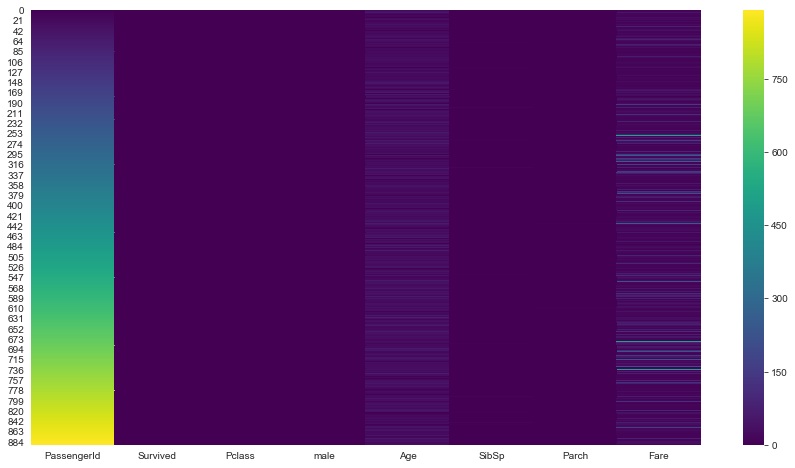

In [69]:
plt.figure(figsize=(15,8))
sns.heatmap(df,cmap='viridis')

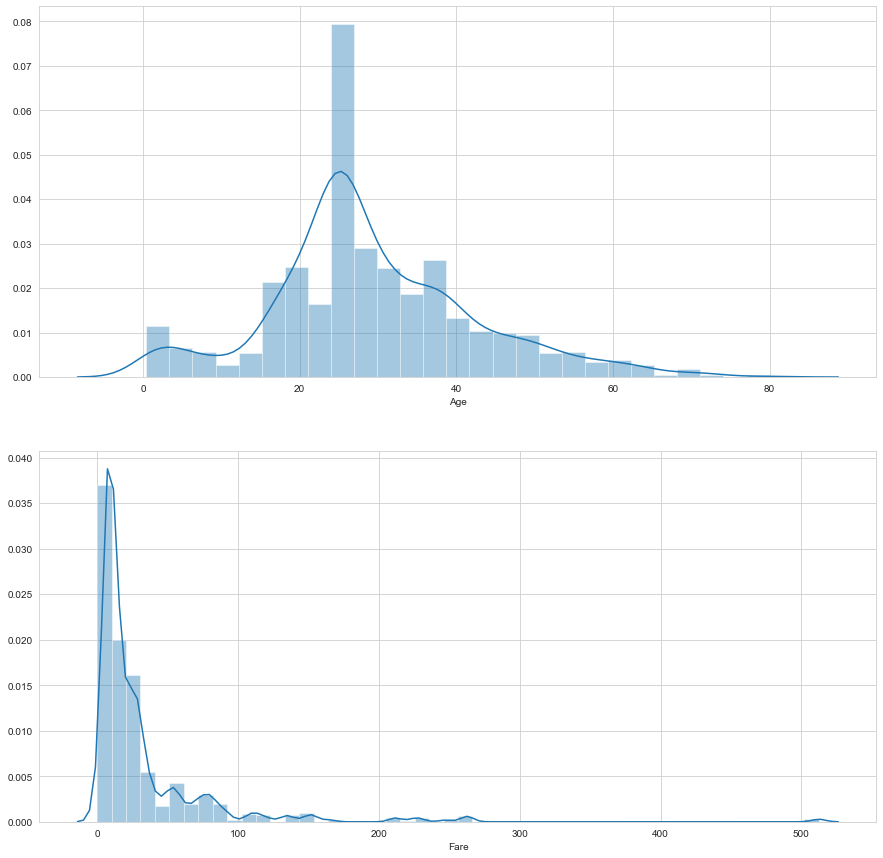

In [70]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,15))
sns.distplot(df['Age'], ax=axes[0])
sns.distplot(df['Fare'], ax=axes[1])

In [71]:
check_normal_dist = ['Fare','Age']

for element in check_normal_dist:
    alpha = 0.05
    stat, p = shapiro(df[element])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    if p > alpha:
        print('{} is Gaussian-like. Failed to reject H0'.format(element))
    else:
        print('{} is not Gaussian-like. H0 has been  rejected'.format(element))

Statistics=0.520, p=0.000
Fare is not Gaussian-like. H0 has been  rejected
Statistics=0.964, p=0.000
Age is not Gaussian-like. H0 has been  rejected


In [72]:
scaler = preprocessing.RobustScaler()
X = df.drop(['Survived','PassengerId'], axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [73]:
#since business task here is to predict as many correct outputs I will optimize accuracy
results = pd.DataFrame(columns=['test_accuracy','train_accuracy'])

In [74]:
log_reg = LogisticRegression().fit(X_train,y_train)
reg_test_preds = log_reg.predict(X_test)
reg_train_preds = log_reg.predict(X_train)

results.loc['LogisticRegression'] = [accuracy_score(y_test, reg_test_preds),
                                    accuracy_score(y_train, reg_train_preds)]

results

,test_accuracy,train_accuracy
LogisticRegression,0.766854,0.818011


In [75]:
rand_frst = RandomForestClassifier().fit(X_train, y_train)
forest_test_preds = rand_frst.predict(X_test)
forest_train_preds = rand_frst.predict(X_train)

results.loc['RandomForest'] = [accuracy_score(y_test, forest_test_preds),
                            accuracy_score(y_train, forest_train_preds)]

results

,test_accuracy,train_accuracy
LogisticRegression,0.766854,0.818011
RandomForest,0.797753,0.984991


In [76]:
svc = SVC().fit(X_train, y_train)
svc_test_preds = svc.predict(X_test)
svc_train_preds = svc.predict(X_train)

results.loc['SVM'] = [accuracy_score(y_test, svc_test_preds),
                     accuracy_score(y_train, svc_train_preds)]

results

,test_accuracy,train_accuracy
LogisticRegression,0.766854,0.818011
RandomForest,0.797753,0.984991
SVM,0.783708,0.827392


In [77]:
xgboost = XGBClassifier().fit(X_train, y_train)
xgboost_test_preds = xgboost.predict(X_test)
xgboost_train_preds = xgboost.predict(X_train)

results.loc['XGBoost'] = [accuracy_score(y_test, xgboost_test_preds),
                         accuracy_score(y_train, xgboost_train_preds)]

results

,test_accuracy,train_accuracy
LogisticRegression,0.766854,0.818011
RandomForest,0.797753,0.984991
SVM,0.783708,0.827392
XGBoost,0.811798,0.896811


In [78]:
boosted_results = pd.DataFrame(columns=['test_accuracy','train_accuracy'])

def optimize_regression(Trial, X_train, X_test, y_train, y_test):
    
    regression_params = {
        'C' : Trial.suggest_float('C', 0.001, 100),
        'max_iter' : Trial.suggest_int('max_iter', 100, 5000),
        #'solver' : Trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
        #'penalty' : Trial.suggest_categorical('penalty', ['l1', 'l2', 'none']),
        }
    
    cv_score = np.mean(cross_val_score(LogisticRegression(**regression_params), X_train, y_train,
                                                          cv=10, scoring='accuracy'))
    
    model = LogisticRegression(**regression_params)
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    train_preds = model.predict(X_train)
    
    test_accuracy = accuracy_score(y_test, test_preds)
    train_accuracy = accuracy_score(y_train, train_preds)
    
    if test_accuracy - train_accuracy < 5:
        return 0
    else:
        return cv_score


#for algorithm in [LogisticRegression, RandomForestClassifier, SVC, XGBClassifier]:
study_regression = optuna.create_study(direction='maximize')
study_regression.optimize(lambda Trial: optimize_regression(Trial, X_train, X_test, 
                            y_train, y_test), n_jobs=-1, n_trials=30)

log_reg = LogisticRegression(**study_regression.best_params).fit(X_train, y_train)

test_regression = log_reg.predict(X_test)
train_regression = log_reg.predict(X_train)

boosted_results.loc['LogisticRegression', 'test_accuracy'] = accuracy_score(y_test, 
                                                           test_regression)

boosted_results.loc['LogisticRegression', 'train_accuracy'] = accuracy_score(y_train, 
                                                           train_regression)
boosted_results

[I 2020-08-31 22:25:30,127] Trial 3 finished with value: 0.0 and parameters: {'C': 1.1811252816693585, 'max_iter': 2615}. Best is trial 3 with value: 0.0.
[I 2020-08-31 22:25:30,135] Trial 0 finished with value: 0.0 and parameters: {'C': 90.8401175517822, 'max_iter': 425}. Best is trial 3 with value: 0.0.
[I 2020-08-31 22:25:30,135] Trial 1 finished with value: 0.0 and parameters: {'C': 11.384869478707893, 'max_iter': 2930}. Best is trial 3 with value: 0.0.
[I 2020-08-31 22:25:30,151] Trial 2 finished with value: 0.0 and parameters: {'C': 45.122526123466066, 'max_iter': 1566}. Best is trial 3 with value: 0.0.
[I 2020-08-31 22:25:30,430] Trial 4 finished with value: 0.0 and parameters: {'C': 12.592758008145033, 'max_iter': 4119}. Best is trial 3 with value: 0.0.
[I 2020-08-31 22:25:30,450] Trial 6 finished with value: 0.0 and parameters: {'C': 55.358454544782624, 'max_iter': 4477}. Best is trial 3 with value: 0.0.
[I 2020-08-31 22:25:30,473] Trial 5 finished with value: 0.0 and paramete

,test_accuracy,train_accuracy
LogisticRegression,0.769663,0.818011


In [79]:
def optimize_forest(Trial, X_train, X_test, y_train, y_test):
    
    forest_params =  {
        'max_depth' : Trial.suggest_int('max_depth', 2, 20),
        'min_samples_leaf' : Trial.suggest_int('min_samples_leaf', 2, 8),
        'min_samples_split' : Trial.suggest_int('min_samples_split', 2, 8),
        'n_estimators' : Trial.suggest_int('n_estimators', 100, 500),
        #'criterion' : Trial.suggest_categorical('criterion', ['mse', 'mae']),
        }
    
    cv_score = np.mean(cross_val_score(RandomForestClassifier(**forest_params), X_train, y_train,
                                                          cv=10, scoring='accuracy'))
    
    model = RandomForestClassifier(**forest_params)
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    train_preds = model.predict(X_train)
    
    test_accuracy = accuracy_score(y_test, test_preds)
    train_accuracy = accuracy_score(y_train, train_preds)
    
    if test_accuracy - train_accuracy < 5:
        return 0
    else:
        return cv_score


#for algorithm in [LogisticRegression, RandomForestClassifier, SVC, XGBClassifier]:
study_forest = optuna.create_study(direction='maximize')
study_forest.optimize(lambda Trial: optimize_forest(Trial, X_train, X_test, 
                            y_train, y_test), n_jobs=-1, n_trials=30)

random_forest = RandomForestClassifier(**study_forest.best_params).fit(X_train, y_train)

test_forest = random_forest.predict(X_test)
train_forest = random_forest.predict(X_train)

boosted_results.loc['RandomForest', 'test_accuracy'] = accuracy_score(y_test, 
                                                           test_forest)

boosted_results.loc['RandomForest', 'train_accuracy'] = accuracy_score(y_train, 
                                                           train_forest)
boosted_results

[I 2020-08-31 22:25:45,877] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 196}. Best is trial 1 with value: 0.0.
[I 2020-08-31 22:25:52,665] Trial 3 finished with value: 0.0 and parameters: {'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 243}. Best is trial 1 with value: 0.0.
[I 2020-08-31 22:25:55,957] Trial 2 finished with value: 0.0 and parameters: {'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 303}. Best is trial 1 with value: 0.0.
[I 2020-08-31 22:25:57,727] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 320}. Best is trial 1 with value: 0.0.
[I 2020-08-31 22:26:00,713] Trial 5 finished with value: 0.0 and parameters: {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 160}. Best is trial 1 with value: 0.0.
[I 2020-08-31 22:

,test_accuracy,train_accuracy
LogisticRegression,0.769663,0.818011
RandomForest,0.797753,0.834897


In [80]:
def optimize_svc(Trial, X_train, X_test, y_train, y_test):
    
    svm_params =  {
        'C' : Trial.suggest_float('C', 0.001, 100),
        'gamma' : Trial.suggest_float('gamma', 0.0001, 1),
        #'kernel' : Trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'])
    }
    
    cv_score = np.mean(cross_val_score(SVC(**svm_params), X_train, y_train,
                                                          cv=10, scoring='accuracy'))
    
    model = SVC(**svm_params)
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    train_preds = model.predict(X_train)
    
    test_accuracy = accuracy_score(y_test, test_preds)
    train_accuracy = accuracy_score(y_train, train_preds)
    
    if test_accuracy - train_accuracy < 5:
        return 0
    else:
        return cv_score


#for algorithm in [LogisticRegression, RandomForestClassifier, SVC, XGBClassifier]:
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(lambda Trial: optimize_svc(Trial, X_train, X_test, 
                            y_train, y_test), n_jobs=-1, n_trials=30)

svc = SVC(**study_svm.best_params).fit(X_train, y_train)

test_svc = svc.predict(X_test)
train_svc = svc.predict(X_train)

boosted_results.loc['SVM', 'test_accuracy'] = accuracy_score(y_test, 
                                                           test_svc)

boosted_results.loc['SVM', 'train_accuracy'] = accuracy_score(y_train, 
                                                           train_svc)
boosted_results

[I 2020-08-31 22:27:49,545] Trial 2 finished with value: 0.0 and parameters: {'C': 26.71052733372747, 'gamma': 0.35441282082379383}. Best is trial 2 with value: 0.0.
[I 2020-08-31 22:27:49,557] Trial 1 finished with value: 0.0 and parameters: {'C': 78.04097477237457, 'gamma': 0.030888941392874306}. Best is trial 2 with value: 0.0.
[I 2020-08-31 22:27:49,637] Trial 0 finished with value: 0.0 and parameters: {'C': 41.48717458634505, 'gamma': 0.4120093643165528}. Best is trial 2 with value: 0.0.
[I 2020-08-31 22:27:49,687] Trial 3 finished with value: 0.0 and parameters: {'C': 81.12311774562744, 'gamma': 0.16712868337174974}. Best is trial 2 with value: 0.0.
[I 2020-08-31 22:27:49,885] Trial 6 finished with value: 0.0 and parameters: {'C': 5.649212957556084, 'gamma': 0.855821363900093}. Best is trial 2 with value: 0.0.
[I 2020-08-31 22:27:49,937] Trial 4 finished with value: 0.0 and parameters: {'C': 15.292912153913107, 'gamma': 0.805539577684217}. Best is trial 2 with value: 0.0.
[I 2020

,test_accuracy,train_accuracy
LogisticRegression,0.769663,0.818011
RandomForest,0.797753,0.834897
SVM,0.792135,0.885553


In [81]:
def optimize_xgb(Trial, X_train, X_test, y_train, y_test):
    
    xgb_params =  {
        'C' : Trial.suggest_float('C', 0.001, 100),
        'gamma' : Trial.suggest_float('gamma', 0.0001, 1),
        'kernel' : Trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'])
    }
    
    cv_score = np.mean(cross_val_score(XGBClassifier(**xgb_params), X_train, y_train,
                                                          cv=10, scoring='accuracy'))
    
    model = XGBClassifier(**xgb_params)
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    train_preds = model.predict(X_train)
    
    test_accuracy = accuracy_score(y_test, test_preds)
    train_accuracy = accuracy_score(y_train, train_preds)
    
    if test_accuracy - train_accuracy < 5:
        return 0
    else:
        return cv_score


#for algorithm in [LogisticRegression, RandomForestClassifier, SVC, XGBClassifier]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(lambda Trial: optimize_xgb(Trial, X_train, X_test, 
                            y_train, y_test), n_jobs=-1, n_trials=30)

xgb = XGBClassifier(**study_xgb.best_params).fit(X_train, y_train)

test_xgb = xgb.predict(X_test)
train_xgb = xgb.predict(X_train)

boosted_results.loc['XGB', 'test_accuracy'] = accuracy_score(y_test, 
                                                           test_xgb)

boosted_results.loc['XGB', 'train_accuracy'] = accuracy_score(y_train, 
                                                           train_xgb)
boosted_results

[I 2020-08-31 22:27:57,088] Trial 3 finished with value: 0.0 and parameters: {'C': 15.663899407649128, 'gamma': 0.11688743660949016, 'kernel': 'precomputed'}. Best is trial 3 with value: 0.0.
[I 2020-08-31 22:27:57,302] Trial 2 finished with value: 0.0 and parameters: {'C': 39.993552888176026, 'gamma': 0.32755811714992655, 'kernel': 'rbf'}. Best is trial 3 with value: 0.0.
[I 2020-08-31 22:27:57,344] Trial 0 finished with value: 0.0 and parameters: {'C': 80.26256971849739, 'gamma': 0.7906394922310085, 'kernel': 'poly'}. Best is trial 3 with value: 0.0.
[I 2020-08-31 22:27:57,586] Trial 1 finished with value: 0.0 and parameters: {'C': 87.39983481555444, 'gamma': 0.47022453622752036, 'kernel': 'rbf'}. Best is trial 3 with value: 0.0.
[I 2020-08-31 22:28:00,971] Trial 4 finished with value: 0.0 and parameters: {'C': 12.496611492112716, 'gamma': 0.5573195538840794, 'kernel': 'linear'}. Best is trial 3 with value: 0.0.
[I 2020-08-31 22:28:01,266] Trial 6 finished with value: 0.0 and paramet

,test_accuracy,train_accuracy
LogisticRegression,0.769663,0.818011
RandomForest,0.797753,0.834897
SVM,0.792135,0.885553
XGB,0.814607,0.898687
